#### Models used from https://github.com/fonnesbeck/gp_regression/blob/master/notebooks/spawning_salmon.ipynb
#### Hope this is ok, asked on Piazza

In [1]:
import os

%matplotlib inline
import numpy as np
import pandas as pd
import pymc3 as pm
import arviz as az
import theano.tensor as tt
import matplotlib.pyplot as plt
from theano import function
from theano.tensor import _shared
from scipy import special
from scipy.stats import weibull_min 
from scipy.optimize import curve_fit

import warnings
warnings.simplefilter('ignore')

os.environ['MKL_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'

In [2]:
import git
import sys
repo = git.Repo("./", search_parent_directories=True)
homedir = repo.working_dir
sys.path.insert(1, f"{homedir}" + '/models/data_processing')
import loader

In [3]:
def process_data(data_covid, data_population, save=True):
	covid = loader.load_data(data_covid)
	loader.convert_dates(covid, "date")
	population = loader.load_data(data_population)
	covid.loc[covid["county"]=='New York City', "fips"]=36061
	covid['Population'] = covid.apply(lambda row: loader.query(population, "FIPS", row.fips)['total_pop'], axis=1)
	covid.dropna(subset=['fips'], inplace=True)
	covid['fips']=covid['fips'].astype(int)
	# covid = add_active_cases(covid, "/data/us/covid/JHU_daily_US.csv")
	if save:
		covid.to_csv(f"{homedir}" + "/models/gaussian/us_training_data.csv")
	return covid

def fit_single_county(input_dict):
	#put the logic to fit a single county here
	#all the data should be in input_dict
	us = input_dict["us"]
	policies = input_dict["policies"]
	county = input_dict["county"]
	end = input_dict["end"]
	death_metric = input_dict["death_metric"]

	county_data = loader.query(us, "fips", county)
	county_data['avg_deaths'] = county_data.iloc[:,6].rolling(window=3).mean()
	county_data = county_data[2:]
	if len(county_data) == 0:
		return None

	dates = pd.to_datetime(county_data["date"].values)
	extrapolate = (end-dates[-1])/np.timedelta64(1, 'D')

	noise = calculate_noise(county_data, death_metric=death_metric)
	X_pred = np.arange(0, len(county_data)+extrapolate).reshape(-1,1)
	X_train = np.arange(0, len(county_data)).reshape(-1, 1)
	Y_train = county_data[death_metric].values

	mean, std_error = fit(X_train, Y_train, X_pred, noise)
	print(mean[len(county_data):])

	# Try using object oriented design. 
	# Create an instance for each county, pass the county specific parameters as instance variables, so we dont have to keep passing them between functions
	# To get results (death_cdf), call its main function below, and return them in the tuple

	# death_cdf = []
	# return (dates, death_cdf, county) 
	return None

def multi_submission(end, death_metric="deaths"):
	counties_dates = []
	counties_death_errors = []
	counties_fips = []

	# This first line regenerates the us_training_data.csv with new data pulled from upstream. It is usually commented out because I dont want to run it every time I test this function.
	# us = process_data("/data/us/covid/nyt_us_counties_daily.csv", "/data/us/demographics/county_populations.csv")
	us = loader.load_data("/models/gaussian/us_training_data.csv")
	policies = loader.load_data("/data/us/other/policies.csv")
	fips_key = loader.load_data("/data/us/processing_data/fips_key.csv", encoding="latin-1")
	# fips_list = fips_key["FIPS"]
	fips_list = [36061]

	data = []
	for index, county in enumerate(fips_list):
		input_dict = {}
		input_dict["us"] = us
		input_dict["policies"] = policies
		input_dict["county"] = county
		input_dict["end"] = end
		input_dict["death_metric"] = death_metric
		data.append(input_dict)
	
	pool = Pool(os.cpu_count())
	results = pool.map(fit_single_county, data)
	
	for result in results:
		if result is not None:
			(dates, death_cdf, county) = result
			counties_dates.append(dates)
			counties_death_errors.append(death_cdf)
			counties_fips.append(county)

	output_dict = {"counties_dates": np.array(counties_dates), "counties_death_errors": np.array(counties_death_errors), "counties_fips": np.array(counties_fips)}
	return output_dict

In [4]:
class Weibull(pm.gp.mean.Mean):
    # custom mean -- Weibull PDF
    def __init__(self, c, loc, scale):
        #Mean.__init__(self)
        self.c = c
        self.loc = loc
        self.scale = scale

    def __call__(self, X):
        X = _shared(X)
        for i in range(0, X.shape[0].eval()):
            X = tt.set_subtensor(X[i], self.c * (((X[i].eval() - self.loc) / self.scale)**(self.c - 1.0)) * 
                                 (np.e ** (-1.0 * (((X[i].eval() - self.loc) / self.scale)**self.c))) / self.scale)
        X = X.reshape((X.shape[0],),)
        return X

In [5]:
# load data, from prototype

df = pd.read_csv('us_training_data.csv')
data = df[['fips', 'deaths', 'date_processed']]
data.head()

,fips,deaths,date_processed
0,53061,0.0,0.0
1,53061,0.0,1.0
2,53061,0.0,2.0
3,53061,0.0,3.0
4,53061,0.0,4.0


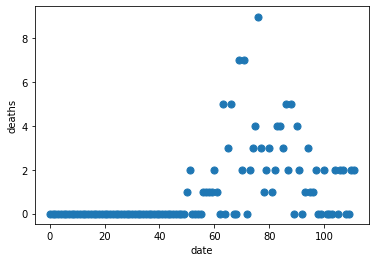

In [6]:
# test on county 53061 first

test_data = [[], []]
fips_list = list(data['fips'])
dates_list = list(data['date_processed'])
deaths_list = list(data['deaths'])

for i in range(0, len(data)):
    if fips_list[i] == 53061:
        date = dates_list[i]
        deaths = deaths_list[i]
        test_data[0].append(date)
        test_data[1].append(deaths)

test_data = np.array(test_data).transpose()
test_data = pd.DataFrame(test_data)
test_data.columns = ['date', 'deaths']
#print(test_data)

test_data.plot.scatter(x='date', y='deaths', s=50);

In [7]:
rolling_deaths = []
for i in range(0, len(test_data)):
    if i == 0:
        rolling_deaths.append(test_data['deaths'][0])
    elif i == 1:
        rolling_deaths.append((test_data['deaths'][0] + test_data['deaths'][1]) / 2.0)
    else:
        rolling_deaths.append((test_data['deaths'][i - 2] + test_data['deaths'][i - 1] + test_data['deaths'][i]) / 3)
test_data['avg_deaths'] = rolling_deaths
print(test_data.head())

   date  deaths  avg_deaths
0   0.0     0.0         0.0
1   1.0     0.0         0.0
2   2.0     0.0         0.0
3   3.0     0.0         0.0
4   4.0     0.0         0.0


In [8]:
with pm.Model() as covid_model:
    m_val = max(test_data.avg_deaths)
    c, loc, scale = weibull_min.fit(np.array(test_data.avg_deaths))
    μ = pm.HalfCauchy('μ', m_val / 10.0)
    l = pm.HalfCauchy('l', 3)
    
    weibull_mean = Weibull(c = c, loc = loc, scale = scale)
    K = (μ**2) * pm.gp.cov.ExpQuad(1, l)
    σ = pm.HalfNormal('σ', m_val / 20)
    
    recruit_gp = pm.gp.Marginal(mean_func=weibull_mean, cov_func=K)
    recruit_gp.marginal_likelihood('deaths', X=test_data.date.values.reshape(-1,1), 
                           y=test_data.avg_deaths.values, noise=σ)

In [ ]:
with covid_model:
    gp_trace = pm.sample(1000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


In [ ]:
# modelling function

In [11]:
# get fips codes
fips_codes = []

# for each fips code, train a model, get predictions til june 30th, write to a csv

,fips,deaths,date_processed
0,53061,0.0,0.0
1,53061,0.0,1.0
2,53061,0.0,2.0
3,53061,0.0,3.0
4,53061,0.0,4.0
